In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

import itertools as it

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as time

In [18]:
data = pd.read_csv('MedicalPremium.csv')
data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [19]:
data.describe()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,24336.713996
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,6248.184382
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,15000.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,21000.000000
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,23000.000000
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,28000.000000
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,40000.000000


In [20]:
y = data['PremiumPrice']
X = data.drop(columns = 'PremiumPrice')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)



# Basic Model

In [21]:
#basic decision tree model with default parameters and random_state = 45
basicmodel = DecisionTreeRegressor(random_state=45) 
basicmodel = basicmodel.fit(X_train, y_train)

In [22]:
#decision tree RMSE 
np.sqrt(mean_squared_error(y_test, basicmodel.predict(X_test)))

2915.4759474226503

# Random Forest 

In [23]:
#grid search 1
param_grid = {
    'max_depth': [12,15,18],
    'max_leaf_nodes': range(25,250, 50),
    'max_features': range(1,4),
    'n_estimators': range(1,30,10)
}
skf = StratifiedKFold(n_splits=5)

grid = GridSearchCV(RandomForestRegressor(random_state=45), param_grid, scoring= 'neg_mean_squared_error', cv=skf, n_jobs=-1, verbose = True)
grid.fit(X_train,y_train)
grid.best_estimator_

Fitting 5 folds for each of 135 candidates, totalling 675 fits


/Users/amandatsuetaki/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomForestRegressor(max_depth=15, max_features=3, max_leaf_nodes=225,
                      n_estimators=21, random_state=45)

In [24]:
print(np.sqrt(grid.best_score_)) # Best accuracy that the grid returns
print(grid.best_params_) # Best hyperparam combo
cv_results = pd.DataFrame(grid.cv_results_)

nan
{'max_depth': 15, 'max_features': 3, 'max_leaf_nodes': 225, 'n_estimators': 21}


/var/folders/nw/zm64_12d7lqck058z9xvmqq40000gn/T/ipykernel_4260/1356221127.py:1: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(grid.best_score_)) # Best accuracy that the grid returns


In [31]:
# grid search 1 -> rf_A
rf_A = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'],max_depth=grid.best_params_['max_depth'],
max_leaf_nodes=grid.best_params_['max_leaf_nodes'],max_features=grid.best_params_['max_features'],random_state= 42)

rf_A=rf_A.fit(X_train,y_train)
# RMSE of rf_A
np.sqrt(mean_squared_error(y_test, rf_A.predict(X_test)))

2736.0580415604586

In [77]:
# feature importances 
imp = rf_final.feature_importances_

fi_df = pd.DataFrame(columns = ['predictor', 'rank'])
fi_df.loc[:, 'predictor'] = X_train.columns
fi_df.loc[:, 'rank'] = imp
fi_df = fi_df.sort_values('rank', ascending = False)
print(fi_df)

                 predictor      rank
0                      Age  0.591302
6                   Weight  0.117328
3           AnyTransplants  0.086449
5                   Height  0.066020
9   NumberOfMajorSurgeries  0.046415
4       AnyChronicDiseases  0.032599
2    BloodPressureProblems  0.021369
8  HistoryOfCancerInFamily  0.018237
1                 Diabetes  0.011421
7           KnownAllergies  0.008860


# Random Forest -- max features and bootstrap check

In [84]:
# grid search 2
params = {'max_features': range(1,26), 
          'bootstrap': [True, False]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150), param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
-8150705.186379639 {'bootstrap': True, 'max_features': 9}


/Users/amandatsuetaki/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/amandatsuetaki/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/amandatsuetaki/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/amandatsuetaki/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1056, in __call__
    self.

In [85]:
# Grid Search 2 -> rf_B
rf_B = RandomForestRegressor(random_state=45, max_features =9,bootstrap = True) 
rf_B.fit(X_train, y_train)
# RMSE of rf_B
np.sqrt(mean_squared_error(y_test, rf_B.predict(X_test)))

2509.740720641972

In [88]:
# Grid Search 2 -> rf_C
rf_C = RandomForestRegressor(random_state=45, max_features =9,bootstrap = False) 
rf_C.fit(X_train, y_train)
#RMSE of rf_C
np.sqrt(mean_squared_error(y_test, rf_C.predict(X_test)))

2423.6041489292493

# Random Forest -- max_leaf_nodes, max_depth

In [111]:
# Grid Search 3
params = {'max_leaf_nodes': range(100,500,100), 
          'max_depth': [5,10,15,20,25,30,35]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150, max_features =9,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
-8414949.152049337 {'max_depth': 10, 'max_leaf_nodes': 100}


In [112]:
# Grid Search 3 -> rf_D
rf_D = RandomForestRegressor(random_state=45, max_features =9, max_depth =10, max_leaf_nodes = 100, bootstrap = True) 
rf_D.fit(X_train, y_train)
# RMSE of rf_D
np.sqrt(mean_squared_error(y_test, rf_D.predict(X_test)))

2533.4067688797904

In [113]:
# Grid Search 3 -> rf_E
rf_E = RandomForestRegressor(random_state=45, max_features =9, max_depth =10, max_leaf_nodes = 100, bootstrap = False) 
rf_E.fit(X_train, y_train)
# RMSE of rf_E
np.sqrt(mean_squared_error(y_test, rf_E.predict(X_test)))

2477.168878045213

In [114]:
# getting the CV response
cv_results = pd.DataFrame(rf_grid.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.268084,0.023008,0.026726,0.004343,5,100,"{'max_depth': 5, 'max_leaf_nodes': 100}",-8.432883e+06,-1.206444e+07,-1.188258e+07,-4.115404e+06,-9.209993e+06,-9.141060e+06,2.892251e+06,28
1,0.318634,0.068270,0.029307,0.008214,5,200,"{'max_depth': 5, 'max_leaf_nodes': 200}",-8.432883e+06,-1.206444e+07,-1.188258e+07,-4.115404e+06,-9.209993e+06,-9.141060e+06,2.892251e+06,25
2,0.248525,0.052158,0.038309,0.008697,5,300,"{'max_depth': 5, 'max_leaf_nodes': 300}",-8.432883e+06,-1.206444e+07,-1.188258e+07,-4.115404e+06,-9.209993e+06,-9.141060e+06,2.892251e+06,25
3,0.287569,0.040809,0.048854,0.010007,5,400,"{'max_depth': 5, 'max_leaf_nodes': 400}",-8.432883e+06,-1.206444e+07,-1.188258e+07,-4.115404e+06,-9.209993e+06,-9.141060e+06,2.892251e+06,25
4,0.299390,0.059521,0.034748,0.010092,10,100,"{'max_depth': 10, 'max_leaf_nodes': 100}",-7.275906e+06,-1.121982e+07,-1.054932e+07,-4.751795e+06,-8.277905e+06,-8.414949e+06,2.330568e+06,1


Text(0, 0.5, 'K-fold MAE')

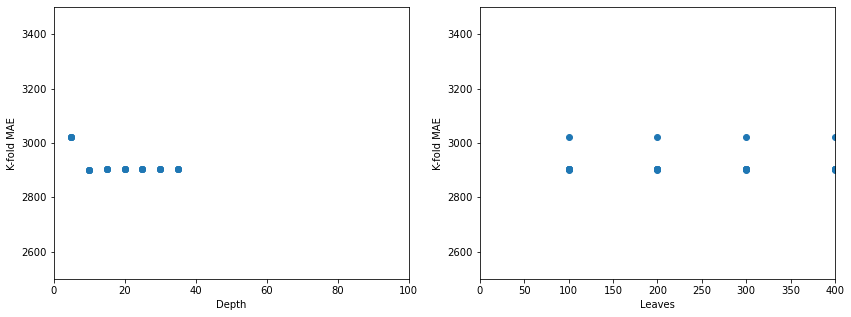

In [115]:
# getting a plot of depth and leaves 
fig, axes = plt.subplots(1,2,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, np.sqrt(-cv_results.mean_test_score), 'o')
axes[0].set_xlim([0,100])
axes[0].set_ylim([2500,3500])
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold MAE')
axes[1].plot(cv_results.param_max_leaf_nodes, np.sqrt(-cv_results.mean_test_score), 'o')
axes[1].set_xlim([0,400])
axes[1].set_ylim([2500,3500])
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('K-fold MAE')

# zoom in corse grid search on max_leaf_nodes

In [121]:
# Grid Search 4
params = {'max_leaf_nodes': range(25,75,5), 
          'max_depth': [1,3,5,7]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150, max_features =9,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
-8140719.147659877 {'max_depth': 7, 'max_leaf_nodes': 25}


In [122]:
# Grid Search 4 -> rf_F
rf_F = RandomForestRegressor(random_state=45, max_features =9, max_depth =7, max_leaf_nodes = 25, bootstrap = True) 
rf_F.fit(X_train, y_train)
# RMSE of rf_F
np.sqrt(mean_squared_error(y_test, rf_F.predict(X_test)))

2584.2833328216193

In [123]:
# Grid Search 4 -> rf_G
rf_G = RandomForestRegressor(random_state=45, max_features =9, max_depth =7, max_leaf_nodes = 25, bootstrap = False) 
rf_G.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, rf_G.predict(X_test)))

2294.445129554296

# checking a bit more

In [24]:
#Grid Search5
params = {'max_leaf_nodes': range(50,75,10), 
          'max_depth': [5,7,10,13]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150, max_features =9,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
-8300245.767709451 {'max_depth': 10, 'max_leaf_nodes': 50}


In [124]:
# Grid Search 5 -> rf_H
rf_H = RandomForestRegressor(random_state=45, max_features =9, max_depth =10, max_leaf_nodes = 50, bootstrap = False) 
rf_H.fit(X_train, y_train)
# RMSE of rf_H
np.sqrt(mean_squared_error(y_test, rf_H.predict(X_test)))

2260.6542969509105

# adding more params (trying different max_features)

In [127]:
# Grid Search 6
params = {'max_features':["sqrt", "log2"]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
-9384577.907907004 {'max_features': 'sqrt'}


In [128]:
# Grid Search 6 -> rf_I
rf_I = RandomForestRegressor(random_state=45, max_features ='sqrt', max_depth =10, max_leaf_nodes = 50, bootstrap = False) 
rf_I.fit(X_train, y_train)

np.sqrt(mean_squared_error(y_test, rf_I.predict(X_test)))

2814.889804240815